In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,classification_report, f1_score

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df = pd.read_csv("C:\\Users\\UseR\\Downloads\\Dev_data_to_be_shared.csv")

In [5]:
df.head()

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['account_number'].dtypes

dtype('int64')

In [7]:
def preprocess_and_feature_engineering(df):
    # Handling bureau_enquiry
    bureau_enq_cols = [col for col in df.columns if col.startswith('bureau_enquiry')]
    df['total_enquiries'] = df[bureau_enq_cols].sum(axis=1)
    df['avg_enquiries'] = df[bureau_enq_cols].mean(axis=1)
    df['max_enquiries'] = df[bureau_enq_cols].max(axis=1)
    df['zero_periods'] = (df[bureau_enq_cols] == 0).sum(axis=1)
    df['std_dev_enquiries'] = df[bureau_enq_cols].std(axis=1)
    df = df.drop(columns=bureau_enq_cols)

    # Handling bureau
    bureau_cols = [col for col in df.columns if col.startswith('bureau')]
    df['bureau_01'] = df[bureau_cols[0:6]].sum(axis=1) + df[bureau_cols[12:35]].sum(axis=1) + df[bureau_cols[66:115]].sum(axis=1)
    df['bureau_02'] = df[bureau_cols[6:13]].sum(axis=1) + df[bureau_cols[115:128]].sum(axis=1) + df[bureau_cols[389:409]].sum(axis=1)
    df['bureau_03'] = df[bureau_cols[35:67]].sum(axis=1)
    df['bureau_04'] = df[bureau_cols[128:388]].sum(axis=1)
    df['bureau_05'] = df[bureau_cols[409:453]].sum(axis=1)
    df.drop(columns=bureau_cols, inplace=True)

    # Handling onus
    onus_cols = [col for col in df.columns if col.startswith('onus')]

    category_1a = [
        'onus_attribute_3', 'onus_attribute_4', 'onus_attribute_10',
        'onus_attribute_13', 'onus_attribute_16', 'onus_attribute_18',
        'onus_attribute_19', 'onus_attribute_21', 'onus_attribute_22',
        'onus_attribute_24'
    ]

    # Dynamically select columns within the specified range
    category_1b = [
        col for col in df.columns if col.startswith('onus_attribute_') and
        25 <= int(col.split('_')[-1]) <= 42
    ]

    onus_range_columns = category_1a + category_1b

    # Combine both sets of columns
    category_1 = onus_range_columns

    # Ensure only valid columns are considered (in case some columns are missing from the DataFrame)
    onus_feature_1 = [col for col in category_1 if col in df.columns]

    category_2 = ['onus_attribute_6','onus_attribute_8','onus_attribute_11','onus_attribute_14']
    onus_feature_2 = [col for col in category_2 if col in df.columns]

    category_3 = ['onus_attribute_2','onus_attribute_5','onus_attribute_7','onus_attribute_9','onus_attribute_12','onus_attribute_15','onus_attribute_17','onus_attribute_20','onus_attribute_23']
    onus_feature_3 = [col for col in category_3 if col in df.columns]

    df['onus_attribute_01'] = df[onus_feature_1].sum(axis=1)
    df['onus_attribute_02'] = df[onus_feature_2].sum(axis=1)
    df['onus_attribute_03'] = df[onus_feature_3].sum(axis=1)
    df['onus_attribute_04'] = df[onus_cols[43:49]].sum(axis=1)


    df.drop(columns=onus_cols[1:], inplace=True)

    # Handling transaction
    transaction_attribute = [col for col in df.columns if col.startswith('transaction_attribute')]

    # Initialize columns for summed values
    df['transaction_col1'] = 0
    df['transaction_col2'] = 0
    df['transaction_col3'] = 0

    # First loop for the range 0 to 117 with step 3
    for index in range(0, 117, 3):
          # Add values to the transaction columns
          df['transaction_col1'] += df[transaction_attribute[index]]
          df['transaction_col2'] += df[transaction_attribute[index+1]]
          df['transaction_col3'] += df[transaction_attribute[index+2]]

    # Second loop for the range 234 to 664 with step 3
    for index in range(234, 351, 3):
        if index + 3 < len(transaction_attribute) and index + 1 < len(transaction_attribute) and index + 2 < len(transaction_attribute):
            # Add values to the transaction columns
            df['transaction_col1'] += df[transaction_attribute[index]]
            df['transaction_col2'] += df[transaction_attribute[index+1]]
            df['transaction_col3'] += df[transaction_attribute[index+2]]

    df['transaction_col4'] = df[transaction_attribute[118:235]].sum(axis=1)+df[transaction_attribute[352:665]].sum(axis=1)

    df.drop(columns=transaction_attribute, inplace=True)




    #Standardize numerical features
    #scaler = StandardScaler()
    #numerical_cols = df.select_dtypes(include=np.number).columns
    #numerical_cols = numerical_cols.drop('bad_flag', errors='ignore') #Ignore if 'bad_flag' not present
    #df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    print(df.shape)

    return df

In [8]:
df = preprocess_and_feature_engineering(df)

(96806, 21)


### Drop unnecessory null data

In [9]:
#Drop na values
df = df.dropna(subset=['onus_attribute_1'])

### Impute

In [10]:
df.shape

(71575, 21)

In [11]:
# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the data
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Now df_imputed contains the DataFrame with imputed NaN values
# print(df_imputed.head())

In [12]:
df_imputed.shape

(71575, 21)

### Data Sampling

In [13]:
# from sklearn.utils import resample

# # Separate majority and minority classes
# df_majority = df_imputed[df_imputed['bad_flag'] == 0]
# df_minority = df_imputed[df_imputed['bad_flag'] == 1]

# # Upsample minority class to 20% of the majority class size
# df_minority_upsampled = resample(df_minority,
#                                  replace=True,     # sample with replacement
#                                  n_samples=int(len(df_majority) * 0.05),    # 20% of the majority class size
#                                  random_state=123) # reproducible results

# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# # Downsample majority class to match the upsampled minority class size
# df_majority_downsampled = resample(df_majority,
#                                    replace=False,    # sample without replacement
#                                    n_samples=len(df_minority_upsampled),     # to match the upsampled minority class size
#                                    random_state=123) # reproducible results

# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([df_minority_upsampled, df_majority_downsampled])

# # Display new class counts after upsampling and downsampling
# # print("Upsampled DataFrame class distribution:")
# # print(df_upsampled['bad_flag'].value_counts())

# print("\nDownsampled DataFrame class distribution:")
# print(df_downsampled['bad_flag'].value_counts())

In [14]:
# !pip install -U imbalanced-learn

In [15]:

from imblearn.over_sampling import SMOTE

# Separate features (X) and target (y)
X = df_imputed.drop('bad_flag', axis=1)  # Drop 'bad_flag' from features
y = df_imputed['bad_flag']  # 'bad_flag' is the target column

# Apply SMOTE to the whole dataset
# Set sampling_strategy as a dictionary to specify the desired number of samples
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Create a new balanced DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['bad_flag'] = y_res

# Display the class distribution after applying SMOTE
print(f"Class distribution before SMOTE:\n{y.value_counts()}")
print(f"Class distribution after SMOTE:\n{y_res.value_counts()}")

Class distribution before SMOTE:
bad_flag
0.0    70525
1.0     1050
Name: count, dtype: int64
Class distribution after SMOTE:
bad_flag
0.0    70525
1.0    70525
Name: count, dtype: int64


In [16]:
df_resampled.shape

(141050, 21)

In [17]:
df_upsampled = df_resampled #df_imputed #df_downsampled

## Training Model

In [18]:
# Assuming you have the original dataframe `df`
original_account_numbers = df_upsampled['account_number']


In [19]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_upsampled.drop("bad_flag", axis=1)  # Assuming `bad_flag` is the target
y = df_upsampled["bad_flag"]

# Split data (this is where X_test and X_train are generated)
X_train, X_test, y_train, y_test, train_account_numbers, test_account_numbers = train_test_split(
    X, y, original_account_numbers, test_size=0.2, random_state=42
)


In [20]:
X_train['account_number']

94308     65693.840526
47231     63868.000000
57386     77564.000000
124050    79873.342868
712         942.000000
              ...     
110268    41536.327836
119879    77012.560758
103694    73175.808977
131932    48529.000699
121958    21651.692620
Name: account_number, Length: 112840, dtype: float64

In [21]:
train_account_numbers

94308     65693.840526
47231     63868.000000
57386     77564.000000
124050    79873.342868
712         942.000000
              ...     
110268    41536.327836
119879    77012.560758
103694    73175.808977
131932    48529.000699
121958    21651.692620
Name: account_number, Length: 112840, dtype: float64

In [22]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop("account_number", axis=1))
X_test_scaled = scaler.transform(X_test.drop("account_number", axis=1))

# Add account_number back to the scaled data if necessary (though it doesn't affect training)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns.drop("account_number"))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns.drop("account_number"))


Processing: Random Forest

Confusion Matrix for Random Forest:
 [[13962   272]
 [  138 13838]]


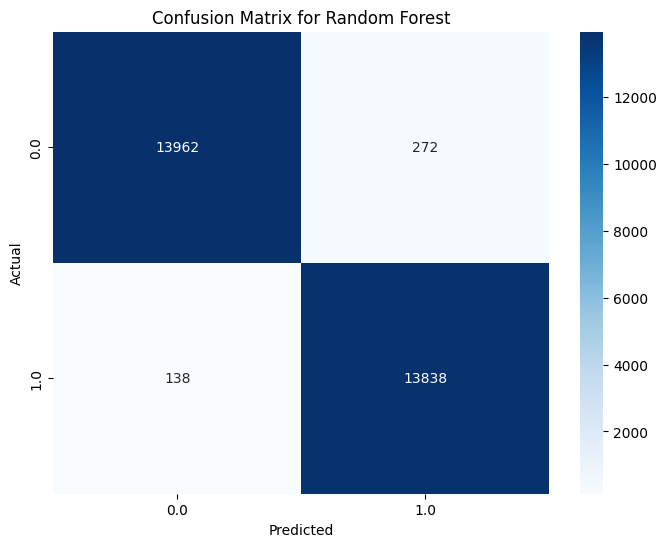

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     14234
         1.0       0.98      0.99      0.99     13976

    accuracy                           0.99     28210
   macro avg       0.99      0.99      0.99     28210
weighted avg       0.99      0.99      0.99     28210

Processing: Decision Tree

Confusion Matrix for Decision Tree:
 [[13499   735]
 [  379 13597]]


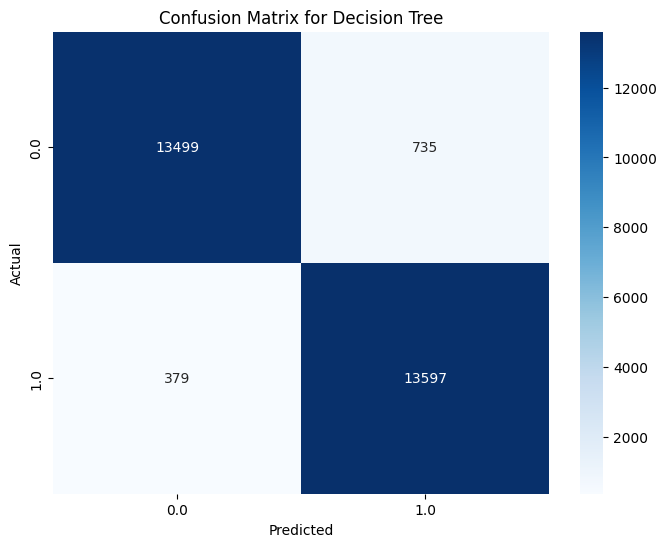

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     14234
         1.0       0.95      0.97      0.96     13976

    accuracy                           0.96     28210
   macro avg       0.96      0.96      0.96     28210
weighted avg       0.96      0.96      0.96     28210

Test probabilities have been calculated and saved to 'test_predictions.csv'.


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Define a list of classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Dictionary to store the probabilities
test_probabilities = {}

# Iterate through classifiers
for name, clf in classifiers.items():
    print(f"Processing: {name}")
    
    # Train the model on the training data
    clf.fit(X_train_scaled, y_train)
    
    # Predict probabilities for the test dataset
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]  # Probability of default (class 1)
    elif hasattr(clf, "decision_function"):
        y_prob = clf.decision_function(X_test_scaled)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalize to [0, 1]
    else:
        raise ValueError(f"Classifier {name} does not support probability predictions.")
    
    # Store the probabilities
    test_probabilities[name] = y_prob

    # Predict the class labels for the test dataset
    y_pred = clf.predict(X_test_scaled)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", conf_matrix)
    
    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report (optional but helpful for model evaluation)
    print(classification_report(y_test, y_pred))

# Choose the best model (e.g., Random Forest based on evaluation metrics)
selected_model = "Random Forest"  # Change this to the best model after evaluation
y_prob_final = test_probabilities[selected_model]

# Create a DataFrame to save results using the preserved account numbers
test_results = pd.DataFrame({
    "account_number": test_account_numbers,  # Use the preserved account numbers
    "predicted_probability": y_prob_final
})

# Save the results to a CSV file
test_results.to_csv("test_predictions.csv", index=False)
print("Test probabilities have been calculated and saved to 'test_predictions.csv'.")


Full Predicted Probabilities (first 20 examples):
[[0.03 0.97]
 [0.97 0.03]
 [0.71 0.29]
 [0.98 0.02]
 [0.29 0.71]
 [1.   0.  ]
 [0.01 0.99]
 [0.24 0.76]
 [1.   0.  ]
 [0.08 0.92]
 [0.13 0.87]
 [1.   0.  ]
 [0.9  0.1 ]
 [0.99 0.01]
 [0.47 0.53]
 [0.02 0.98]
 [0.89 0.11]
 [1.   0.  ]
 [0.49 0.51]
 [0.86 0.14]]
[0.97 0.03 0.29 ... 0.04 0.16 0.  ]

--- Decision Tree ---
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     14234
         1.0       0.98      0.99      0.99     13976

    accuracy                           0.99     28210
   macro avg       0.99      0.99      0.99     28210
weighted avg       0.99      0.99      0.99     28210



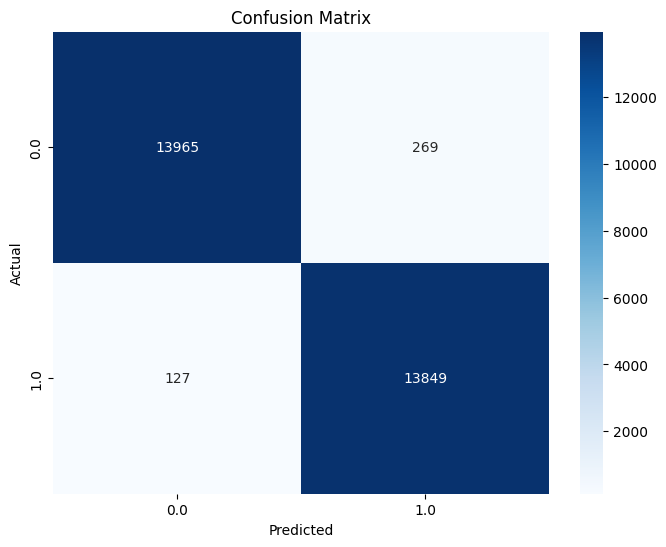

In [24]:
classifiers = {
    # "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    # "XGBoost": XGBClassifier(),
    # "Support Vector Machine": SVC(),
    # "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=2, class_weight='balanced'),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Naive Bayes": GaussianNB()
}


for name, clf in classifiers.items():
  # Train the classifier
  clf.fit(X_train_scaled, y_train)

  # Get predicted probabilities
  y_pred = clf.predict_proba(X_test_scaled)

  # Print out the first 20 predicted probabilities for both classes (0 and 1)
  print("Full Predicted Probabilities (first 20 examples):")
  print(y_pred[:20])  # Probabilities for both classes

  # If you're only interested in the positive class (class 1)
  positive_class_probabilities = y_pred[:, 1]
  print(positive_class_probabilities)
  # Predicted class labels
  y_pred = clf.predict(X_test_scaled)

  # Classification report
  print("\n--- Decision Tree ---")
  print(classification_report(y_test, y_pred))

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [25]:
validation_data=pd.read_csv("C:\\Users\\UseR\\Downloads\\validation_data_to_be_shared.csv")
df = preprocess_and_feature_engineering(validation_data)


(41792, 20)


In [26]:
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [27]:
# Separate the account_number column before scaling
acc_no = df_imputed['account_number']

# Drop account_number from df_imputed as it's not part of the features for scaling
df_imputed_features = df_imputed.drop("account_number", axis=1)

# Apply the scaler to the remaining features
df_imputed_scaled = scaler.transform(df_imputed_features)


In [28]:
# Assuming `clf` is the trained model
y_pred_val = clf.predict(df_imputed_scaled)  # Predict class labels

# If you want probabilities instead of class predictions
if hasattr(clf, "predict_proba"):
    y_prob_val = clf.predict_proba(df_imputed_scaled)[:, 1]  # Probability of class 1 (bad_flag=1)
else:
    y_prob_val = y_pred_val  # If no probabilities, you can just use predictions


d:\code\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\code\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
# Assuming `val_account_numbers` is the list of account numbers corresponding to the validation data
validation_results = pd.DataFrame({
    "account_number": acc_no,  # Account numbers corresponding to validation data
    "predicted_probability": y_prob_val  # Predicted probabilities or class labels
})

validation_results.to_csv("validation_predictions.csv", index=False)
print("Validation predictions have been calculated and saved to 'validation_predictions.csv'.")


Validation predictions have been calculated and saved to 'validation_predictions.csv'.


In [30]:
# Assuming `clf` is the trained model and `df_imputed_scaled` is your test data
if hasattr(clf, "predict_proba"):
    # Get the probabilities for the positive class (bad_flag = 1)
    y_prob_val = clf.predict_proba(df_imputed_scaled)[:, 1]  # Select the probability for class 1 (bad_flag=1)
else:
    raise ValueError("The model does not support probability predictions.")

# Create a DataFrame to store account number and predicted probabilities
probability_results = pd.DataFrame({
    "account_number": acc_no,  # Use the preserved account numbers
    "predicted_probability": y_prob_val  # Probabilities for class 1 (bad_flag=1)
})

# Save to a CSV file
probability_results.to_csv("validation_predictions.csv", index=False)
print("Predicted probabilities have been calculated and saved to 'validation_data_pred.csv'.")


d:\code\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted probabilities have been calculated and saved to 'validation_data_pred.csv'.


### DLmodel

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization
        self.relu1 = nn.Tanh()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch normalization
        self.relu2 = nn.Tanh()
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)  # Batch normalization
        self.relu3 = nn.Tanh()
        self.fc4 = nn.Linear(32, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

        # Apply He initialization to weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)  # Batch normalization
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)  # Reshape for binary classification
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
input_size = X_train_tensor.shape[1]  # Number of features

# Instantiate the model
model = Net(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model.to(device)

# Move the data to the GPU
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Training loop
epochs = 2500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()  # Convert probabilities to binary predictions

    # Move tensors back to CPU for classification_report
    y_pred_cpu = y_pred.cpu()
    y_test_tensor_cpu = y_test_tensor.cpu()

    print(classification_report(y_test_tensor_cpu, y_pred_cpu))


Using device: cpu
Epoch [1/2500], Loss: 0.8398
Epoch [2/2500], Loss: 0.7500
Epoch [3/2500], Loss: 0.6864
Epoch [4/2500], Loss: 0.6497
Epoch [5/2500], Loss: 0.6320
Epoch [6/2500], Loss: 0.6244
Epoch [7/2500], Loss: 0.6212
Epoch [8/2500], Loss: 0.6193
Epoch [9/2500], Loss: 0.6172
Epoch [10/2500], Loss: 0.6143
Epoch [11/2500], Loss: 0.6108
Epoch [12/2500], Loss: 0.6069
Epoch [13/2500], Loss: 0.6030
Epoch [14/2500], Loss: 0.5995
Epoch [15/2500], Loss: 0.5968
Epoch [16/2500], Loss: 0.5949
Epoch [17/2500], Loss: 0.5936
Epoch [18/2500], Loss: 0.5926
Epoch [19/2500], Loss: 0.5918
Epoch [20/2500], Loss: 0.5908
Epoch [21/2500], Loss: 0.5896
Epoch [22/2500], Loss: 0.5882
Epoch [23/2500], Loss: 0.5867
Epoch [24/2500], Loss: 0.5852
Epoch [25/2500], Loss: 0.5838
Epoch [26/2500], Loss: 0.5826
Epoch [27/2500], Loss: 0.5816
Epoch [28/2500], Loss: 0.5806
Epoch [29/2500], Loss: 0.5797
Epoch [30/2500], Loss: 0.5788
Epoch [31/2500], Loss: 0.5779
Epoch [32/2500], Loss: 0.5770
Epoch [33/2500], Loss: 0.5761
E

In [32]:
validation_data=pd.read_csv("C:\\Users\\UseR\\Downloads\\validation_data_to_be_shared.csv")

In [33]:
df = preprocess_and_feature_engineering(validation_data)

(41792, 20)


In [34]:
df.isnull().sum()

account_number           0
onus_attribute_1     10990
total_enquiries          0
avg_enquiries         1127
max_enquiries         1127
zero_periods             0
std_dev_enquiries     1127
bureau_01                0
bureau_02                0
bureau_03                0
bureau_04                0
bureau_05                0
onus_attribute_01        0
onus_attribute_02        0
onus_attribute_03        0
onus_attribute_04        0
transaction_col1     10990
transaction_col2     10990
transaction_col3     10990
transaction_col4         0
dtype: int64

In [35]:
#df = df.dropna(subset=['onus_attribute_1'])

In [36]:
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [37]:
# Separate the account_number column before scaling
acc_no = df_imputed['account_number']

# Drop account_number from df_imputed as it's not part of the features for scaling
df_imputed_features = df_imputed.drop("account_number", axis=1)

# Apply the scaler to the remaining features
df_imputed_scaled = scaler.transform(df_imputed_features)


In [38]:
# Assuming `model` is the trained PyTorch model and `df_imputed_scaled` is the new data for prediction

# Convert new data (NumPy array) to PyTorch tensor
df_tensor = torch.tensor(df_imputed_scaled, dtype=torch.float32)

# Move the tensor to the same device as the model
df_tensor = df_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    # Get the probabilities directly from the model
    y_prob_val = model(df_tensor).cpu().numpy()  # Move probabilities back to CPU and convert to NumPy

# `y_prob_val` contains the probabilities of the positive class (e.g., bad_flag=1)


In [39]:
import pandas as pd

# Flatten the predicted probabilities to 1D
y_prob_val = y_prob_val.flatten()

# Assuming `acc_no` is the list of account numbers corresponding to the validation data
validation_results = pd.DataFrame({
    "account_number": acc_no,  # Account numbers corresponding to validation data
    "predicted_probability": y_prob_val  # Flattened predicted probabilities
})

# Save the results to a CSV file
validation_results.to_csv("validation_predictions.csv", index=False)
print("Validation predictions have been calculated and saved to 'validation_predictions.csv'.")


Validation predictions have been calculated and saved to 'validation_predictions.csv'.


In [40]:
df_out=pd.read_csv("validation_data_pred.csv")

In [41]:
df_out['account_number']

0        100001.0
1        100002.0
2        100003.0
3        100004.0
4        100005.0
           ...   
41787    141788.0
41788    141789.0
41789    141790.0
41790    141791.0
41791    141792.0
Name: account_number, Length: 41792, dtype: float64